Import modules and packages

Run this code in the qiime2-2022.8 environment

In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import seaborn
import argparse
import pathlib
from os.path import join, exists
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           boxplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis,
                                           beta_diversity_pcoa,
                                           average_distance_boxplots,
                                           rank_optimized_method_performance_by_dataset)
from tax_credit.eval_framework import (evaluate_results,
                                       method_by_dataset_a1,
                                       parameter_comparisons,
                                       merge_expected_and_observed_tables,
                                       filter_df)

In [2]:
#Environment preparation
database_name = 'gg_13_8_otus'
outdir = 'plots'
expected_results_dir = join("data/precomputed-results/", "mock-community")
mock_results_fp = join(expected_results_dir, 'mock_results.tsv')
results_dirs = [expected_results_dir]
mock_dir = join("data", "mock-community")
if not os.path.exists(outdir):
    os.makedirs(outdir)
dataset_ids = ['mock-1', 'mock-2', 'mock-3', 'mock-4', 'mock-5','mock-6', 'mock-7', 'mock-8','mock-12','mock-13','mock-14', 'mock-15','mock-16','mock-18', 'mock-19', 'mock-20', 'mock-21', 'mock-22']
method_ids = ['q2-NB', 'q2-SFM-RF', 'q2-SFM-SGD','q2-SFM-NB']
ref_ids = [database_name]

In [3]:
# Find mock community pre-computed tables, expected tables, and "query" tables
# Note: if you have added additional methods to add, set append=True. If you are attempting to recompute pre-computed results, set           force=True.
mock_results = evaluate_results(results_dirs, 
                                expected_results_dir, 
                                mock_results_fp, 
                                mock_dir,
                                taxonomy_level_range=range(2,7), #Define the range of taxonomic levels over which to compute accuracy                                       scores. The default will compute order (level 2) through species (level 6)
                                min_count=1, #Minimum number of times an OTU must be observed for it to be included in analyses. Edit this                                   to analyze the effect of the minimum count on taxonomic results.'
                                taxa_to_keep=None, 
                                md_key='taxonomy', 
                                subsample=False,
                                per_seq_precision=True,
                                exclude=['other'],
                                dataset_ids=dataset_ids,
                                reference_ids=ref_ids,
                                method_ids=method_ids,
                                append=False, #force=True the first time and for appending new methods
                                force=False, #force=True the first time 
                                backup=False)

data/precomputed-results/mock-community/mock_results.tsv already exists.
Reading in pre-computed evaluation results.
To overwrite, set force=True
Results have been filtered to only include datasets or reference databases or methods or parameters that are explicitly set by results params. To disable this function and load all results, set dataset_ids and reference_ids and method_ids and parameter_ids to None.


/home/SE/BMIG-6202-MSR/qiime2-2022.2/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/SE/BMIG-6202-MSR/qiime2-2022.2/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/SE/BMIG-6202-MSR/qiime2-2022.2/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/SE/BMIG-6202-MSR/qiime2-2022.2/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/SE/BMIG-6202-MSR/qiime2-2022.2/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: U

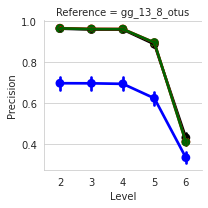

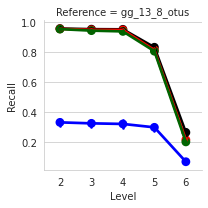

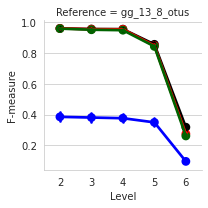

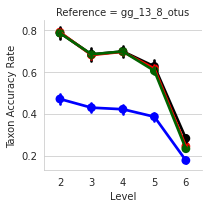

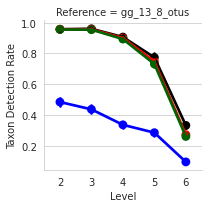

In [4]:
#Compute and summarize precision, recall, and F-measure for mock communities
color_palette={ 
    'q2-NB':'black',
    'q2-SFM-RF':'darkgreen',
    'q2-SFM-SGD':'red',
    'q2-SFM-NB':'blue',
    }
y_vars = ["Precision", "Recall", "F-measure", "Taxon Accuracy Rate", "Taxon Detection Rate"]
point = pointplot_from_data_frame(mock_results, "Level", y_vars, 
                                  group_by="Reference", color_by="Method",
                                  color_palette=color_palette)
for k, v in point.items():
    v.savefig(join(outdir, '{0}-lineplot.pdf'.format(k)),bbox_inches = 'tight')

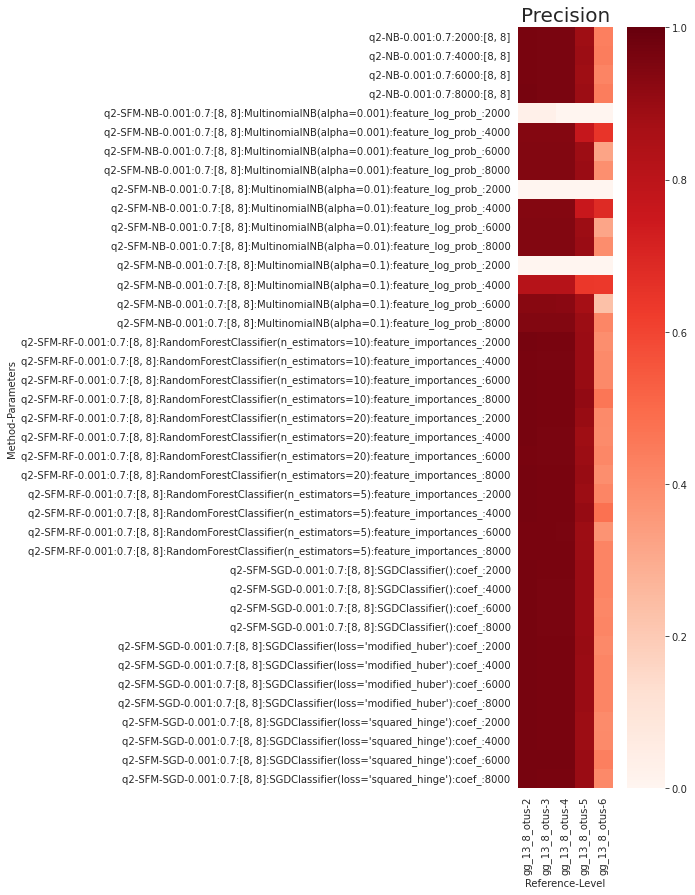

<Figure size 432x288 with 0 Axes>

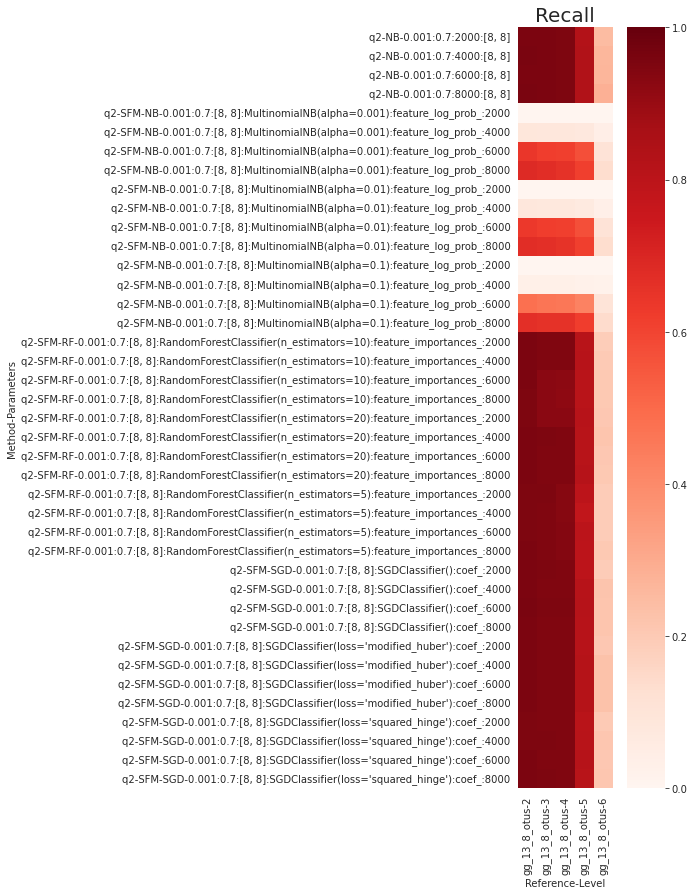

<Figure size 432x288 with 0 Axes>

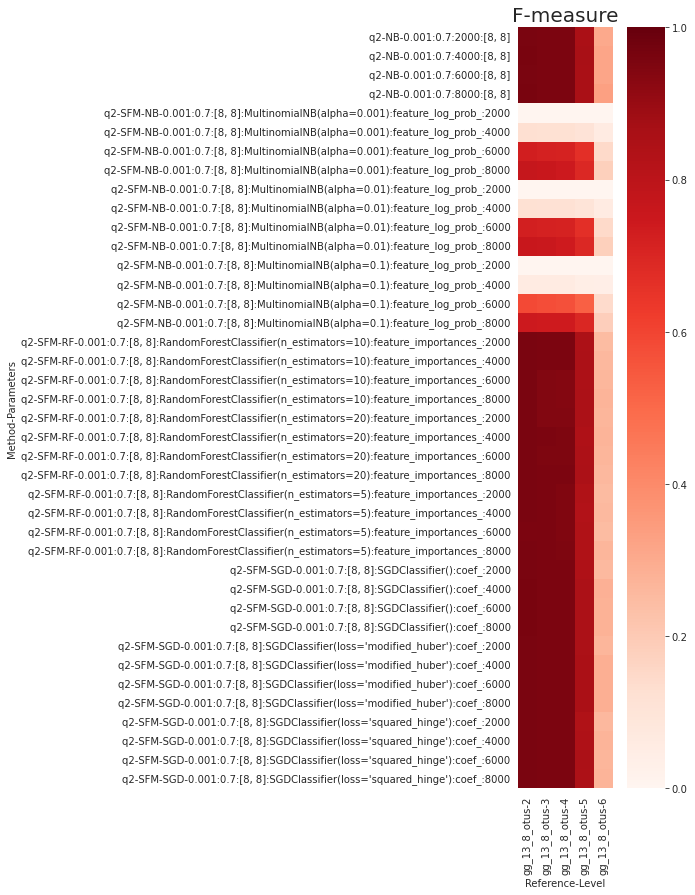

<Figure size 432x288 with 0 Axes>

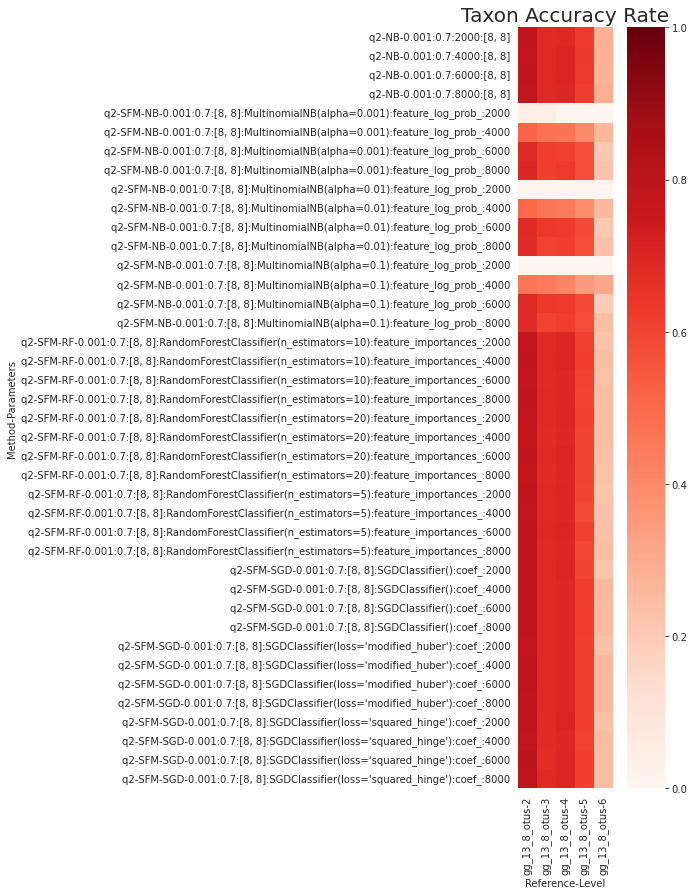

<Figure size 432x288 with 0 Axes>

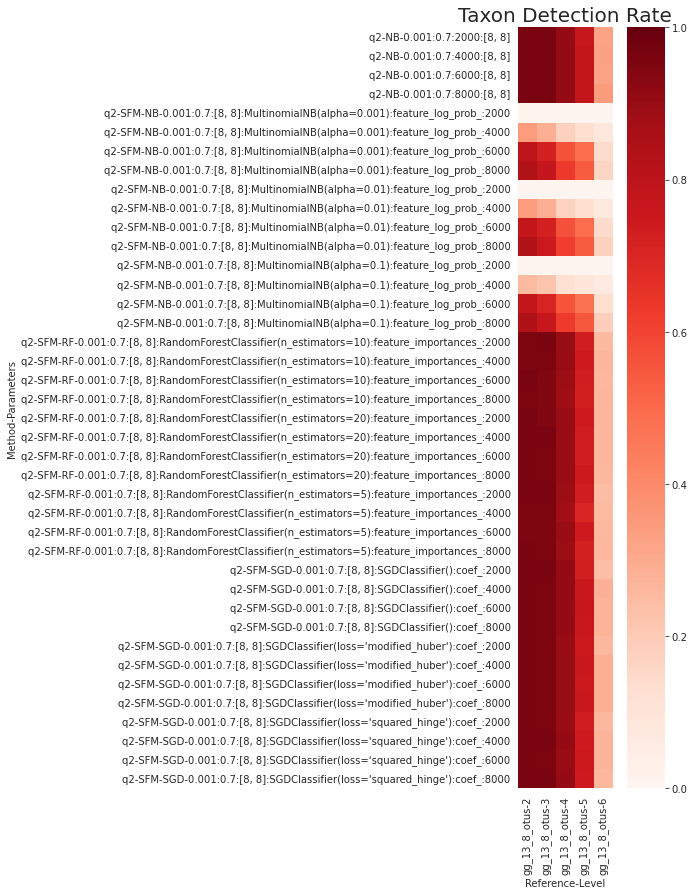

<Figure size 432x288 with 0 Axes>

In [5]:
#Heatmaps show the performance of individual method/parameter combinations at each taxonomic level, in each reference database
heatmap_from_data_frame(mock_results, metric="Precision", rows=["Method", "Parameters"], cols=["Reference","Level"])
plt.savefig(join(outdir, "Precision-heatmap.pdf"), bbox_inches = 'tight')
    
heatmap_from_data_frame(mock_results, metric="Recall", rows=["Method", "Parameters"], cols=["Reference","Level"])
plt.savefig(join(outdir, "Recall-heatmap.pdf"), bbox_inches = 'tight')
    
heatmap_from_data_frame(mock_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Reference","Level"])
plt.savefig(join(outdir, "F-measure-heatmap.pdf"), bbox_inches = 'tight')
    
heatmap_from_data_frame(mock_results, metric="Taxon Accuracy Rate", rows=["Method", "Parameters"], cols=    
                            ["Reference", "Level"])
plt.savefig(join(outdir, "Taxon Accuracy Rate.pdf"), bbox_inches = 'tight')
    
heatmap_from_data_frame(mock_results, metric="Taxon Detection Rate", rows=["Method", "Parameters"], cols=
                            ["Reference", "Level"])
plt.savefig(join(outdir, "Taxon Detection Rate-heatmap.pdf"), bbox_inches = 'tight')

In [6]:
#Now we will focus on results at species level (for genus level, change to level 5)
# Method optimization
# Which method/parameter configuration performed "best" for a given score? We can rank the top-performing configuration by dataset,           method, and taxonomic level. 
# First, the top-performing method/configuration combination by dataset.
mock_results_6 = mock_results[mock_results['Level'] == 6]
pd.set_option('display.max_colwidth', None)
for dataset in mock_results_6['Dataset'].unique():
    display(Markdown('## {0}'.format(dataset)))
    best = method_by_dataset_a1(mock_results_6, dataset)
    display(best)
    best.to_csv(join(outdir, '{0}-best_method.tsv'.format(dataset)),sep='\t')

## mock-20

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
4,q2-NB,"0.001:0.7:8000:[8, 8]",0.431430,0.322209,0.368905,0.291667,0.368421
6669,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier():coef_:4000",0.378686,0.237079,0.291600,0.208333,0.263158
139,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:4000",0.353697,0.237079,0.283878,0.208333,0.263158
6794,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",1.000000,0.119167,0.212956,0.500000,0.105263


## mock-3

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
6838,q2-NB,"0.001:0.7:4000:[8, 8]",0.453090,0.157622,0.233881,0.384615,0.25
758,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:4000",0.817891,0.132625,0.228240,0.307692,0.20
318,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:6000",0.712100,0.132625,0.223605,0.285714,0.20
7439,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.01):feature_log_prob_:8000",0.496680,0.081928,0.140654,0.166667,0.10


## mock-2

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
7639,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:6000",0.728003,0.594806,0.654698,0.365854,0.405405
1004,q2-NB,"0.001:0.7:8000:[8, 8]",0.652199,0.594806,0.622181,0.365854,0.405405
1139,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:4000",0.753534,0.502370,0.602837,0.309524,0.351351
1164,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.682014,0.352422,0.464711,0.363636,0.324324


## mock-21

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
1204,q2-NB,"0.001:0.7:8000:[8, 8]",0.635348,0.366473,0.464829,0.272727,0.315789
1269,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier():coef_:4000",0.609855,0.328168,0.426716,0.181818,0.210526
7939,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:4000",0.607757,0.328168,0.426202,0.181818,0.210526
7994,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",1.000000,0.003817,0.007605,0.333333,0.052632


## mock-18

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
8029,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:6000",0.693938,0.435689,0.535294,0.333333,0.333333
8094,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:2000",0.693295,0.435689,0.535103,0.277778,0.333333
1404,q2-NB,"0.001:0.7:8000:[8, 8]",0.557428,0.435689,0.489097,0.294118,0.333333
1564,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.557550,0.248758,0.344025,0.363636,0.266667


## mock-4

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
8219,q2-NB,"0.001:0.7:8000:[8, 8]",0.488018,0.156813,0.237356,0.230769,0.3
2159,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:4000",0.824053,0.137983,0.236384,0.230769,0.3
8319,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:6000",0.659725,0.137983,0.228231,0.222222,0.3
2259,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.469844,0.083801,0.142233,0.190476,0.2


## mock-19

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
9029,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:6000",0.404018,0.264054,0.319374,0.277778,0.333333
9094,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:2000",0.403354,0.264054,0.319167,0.227273,0.333333
2404,q2-NB,"0.001:0.7:8000:[8, 8]",0.356575,0.264054,0.303418,0.250000,0.333333
9179,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.001):feature_log_prob_:6000",0.000000,0.000000,0.000000,0.000000,0.000000


## mock-15

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
2604,q2-NB,"0.001:0.7:8000:[8, 8]",0.334856,0.272225,0.300310,0.074468,0.35
9269,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier():coef_:4000",0.196764,0.118642,0.148028,0.055556,0.25
9339,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:4000",0.195651,0.118642,0.147712,0.054945,0.25
2794,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",1.000000,0.055743,0.105600,0.181818,0.10


## mock-5

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
9439,q2-NB,"0.001:0.7:4000:[8, 8]",0.586677,0.132006,0.215519,0.296296,0.40
2979,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier():coef_:2000",0.795308,0.118820,0.206752,0.222222,0.30
9919,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:8000",0.569218,0.122120,0.201097,0.250000,0.35
3459,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.384039,0.068890,0.116824,0.200000,0.20


## mock-16

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
3614,q2-NB,"0.001:0.7:2000:[8, 8]",0.270075,0.222134,0.243770,0.168831,0.26
3714,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:4000",0.289866,0.189173,0.228937,0.162162,0.24
10384,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.001):feature_log_prob_:8000",0.405749,0.157921,0.227354,0.196429,0.22
10279,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:2000",0.262799,0.189173,0.219989,0.162162,0.24


## mock-14

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
3804,q2-NB,"0.001:0.7:8000:[8, 8]",0.348550,0.268876,0.303572,0.069307,0.35
3879,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:2000",0.174306,0.102627,0.129190,0.069767,0.30
3939,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:4000",0.182101,0.098879,0.128166,0.054348,0.25
10594,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",1.000000,0.032564,0.063074,0.181818,0.10


## mock-12

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
4154,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.01):feature_log_prob_:4000",1.000000,0.514549,0.679475,0.454545,0.25
4074,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:4000",0.573528,0.519700,0.545289,0.285714,0.50
10694,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:2000",0.573331,0.519280,0.544968,0.243243,0.45
4014,q2-NB,"0.001:0.7:2000:[8, 8]",0.569907,0.519668,0.543630,0.263158,0.50


## mock-6

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
4618,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:4000",0.618465,0.136638,0.223826,0.076923,0.055556
10933,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier():coef_:2000",0.458479,0.141210,0.215917,0.083333,0.074074
4228,q2-NB,"0.001:0.7:4000:[8, 8]",0.408641,0.136638,0.204798,0.104167,0.092593
4678,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.01):feature_log_prob_:8000",0.991078,0.023969,0.046807,0.100000,0.018519


## mock-8

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
4812,q2-NB,"0.001:0.7:8000:[8, 8]",0.820433,0.675368,0.740866,0.574468,0.500000
4917,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:6000",0.780101,0.482051,0.595885,0.512195,0.388889
5144,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:4000",0.756051,0.414951,0.535822,0.425000,0.314815
11954,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.001):feature_log_prob_:8000",0.747296,0.393981,0.515949,0.515152,0.314815


## mock-13

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
5404,q2-NB,"0.001:0.7:8000:[8, 8]",0.346142,0.272617,0.305011,0.084337,0.35
5479,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:2000",0.185513,0.113122,0.140544,0.084507,0.30
5539,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:4000",0.193719,0.108850,0.139382,0.065789,0.25
12194,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",1.000000,0.045271,0.086620,0.222222,0.10


## mock-1

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
5609,q2-NB,"0.001:0.7:4000:[8, 8]",0.499961,0.380347,0.432027,0.318182,0.378378
5624,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:4000",0.617660,0.330199,0.430340,0.270270,0.270270
5724,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=10):feature_importances_:6000",0.602244,0.330199,0.426537,0.263158,0.270270
12384,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.001):feature_log_prob_:8000",0.499214,0.329244,0.396793,0.357143,0.270270


## mock-22

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
5804,q2-NB,"0.001:0.7:8000:[8, 8]",0.450976,0.338973,0.387035,0.189189,0.368421
12534,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:6000",0.376597,0.294809,0.330722,0.171429,0.315789
5849,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier():coef_:8000",0.363830,0.235989,0.286286,0.142857,0.263158
5994,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:4000",1.000000,0.094711,0.173034,0.500000,0.105263


## mock-7

,Method,Parameters,Precision,Recall,F-measure,Taxon Accuracy Rate,Taxon Detection Rate
12657,q2-NB,"0.001:0.7:6000:[8, 8]",0.715887,0.497503,0.587043,0.520000,0.481481
6072,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:4000",0.713512,0.441253,0.545287,0.500000,0.388889
6269,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:6000",0.668428,0.378061,0.482961,0.425000,0.314815
13154,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.001):feature_log_prob_:8000",0.690222,0.333210,0.449446,0.555556,0.277778


In [7]:
#Now we can determine which parameter configuration performed best for each method. Count best values in each column indicate how many 
#samples a given method achieved within one mean absolute deviation of the best      
#result (which is why they may sum to more than the total number of samples).
for method in mock_results_6['Method'].unique():
    top_params = parameter_comparisons(
        mock_results_6, method, 
        metrics=['Taxon Accuracy Rate', 'Taxon Detection Rate', 'Precision', 'Recall', 'F-measure'])
    display(Markdown('## {0}'.format(method)))
    display(top_params[:5])
    top_params[:5].to_csv(join(outdir, '{0}-top_params.tsv'.format(method)),sep='\t')     

## q2-NB

,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
"0.001:0.7:8000:[8, 8]",40,52,48,56,48
"0.001:0.7:4000:[8, 8]",28,28,40,50,42
"0.001:0.7:6000:[8, 8]",26,38,30,52,36
"0.001:0.7:2000:[8, 8]",42,38,36,38,30


## q2-SFM-SGD

,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:6000",38,48,40,62,42
"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:4000",40,54,40,62,42
"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:8000",38,48,40,62,42
"0.001:0.7:[8, 8]:SGDClassifier():coef_:4000",38,52,40,56,40
"0.001:0.7:[8, 8]:SGDClassifier():coef_:8000",36,50,30,50,30


## q2-SFM-RF

,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=10):feature_importances_:8000",38,42,40,46,44
"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:4000",28,32,42,36,42
"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:4000",42,54,18,58,34
"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:6000",38,50,18,58,34
"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=5):feature_importances_:8000",38,44,14,44,24


## q2-SFM-NB

,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",30,66,20,64,64
"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.01):feature_log_prob_:8000",30,58,22,56,56
"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.001):feature_log_prob_:8000",26,42,24,50,50
"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.001):feature_log_prob_:6000",24,40,20,38,44
"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.01):feature_log_prob_:6000",26,40,20,38,44


## gg_13_8_otus level 4

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,q2-NB,"0.001:0.7:6000:[8, 8]",0.699437,0.908557,0.960059,0.952650,0.956259
3,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier(loss='squared_hinge'):coef_:8000",0.699884,0.902470,0.963435,0.948916,0.955831
2,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=10):feature_importances_:2000",0.696758,0.900992,0.962541,0.947591,0.954701
1,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.001):feature_log_prob_:8000",0.625236,0.632069,0.944451,0.659898,0.742496


stat             P         FDR P
Method A   Method B                                        
q2-NB      q2-SFM-SGD  0.458887  6.478465e-01  6.478465e-01
           q2-SFM-RF   1.390966  1.689791e-01  2.319626e-01
           q2-SFM-NB   7.077754  1.264139e-09  2.528277e-09
q2-SFM-SGD q2-SFM-RF   1.314486  1.933021e-01  2.319626e-01
           q2-SFM-NB   7.204149  7.552640e-10  2.528277e-09
q2-SFM-RF  q2-SFM-NB   7.159415  9.063748e-10  2.528277e-09

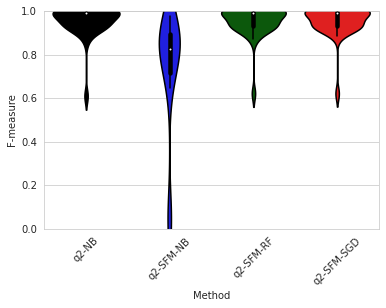

## gg_13_8_otus level 5

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,q2-NB,"0.001:0.7:4000:[8, 8]",0.629733,0.776511,0.892840,0.834502,0.859861
3,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:4000",0.619512,0.753907,0.897673,0.822380,0.854011
2,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:8000",0.604166,0.744291,0.898667,0.816621,0.851249
1,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.580765,0.546890,0.893498,0.618424,0.696839


stat             P         FDR P
Method A   Method B                                        
q2-NB      q2-SFM-SGD  4.006948  1.608507e-04  2.412761e-04
           q2-SFM-RF   3.766380  3.589178e-04  4.307014e-04
           q2-SFM-NB   9.072655  3.690305e-13  1.900498e-12
q2-SFM-SGD q2-SFM-RF   1.843787  6.977304e-02  6.977304e-02
           q2-SFM-NB   8.939340  6.334994e-13  1.900498e-12
q2-SFM-RF  q2-SFM-NB   8.669200  1.899328e-12  3.798655e-12

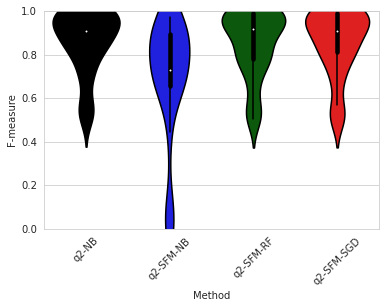

## gg_13_8_otus level 6

,Method,Parameters,Taxon Accuracy Rate,Taxon Detection Rate,Precision,Recall,F-measure
0,q2-NB,"0.001:0.7:8000:[8, 8]",0.288332,0.345750,0.439321,0.281656,0.332507
3,q2-SFM-SGD,"0.001:0.7:[8, 8]:SGDClassifier(loss='modified_huber'):coef_:4000",0.257687,0.287113,0.416197,0.229898,0.287995
2,q2-SFM-RF,"0.001:0.7:[8, 8]:RandomForestClassifier(n_estimators=20):feature_importances_:4000",0.239236,0.266723,0.397330,0.215255,0.271738
1,q2-SFM-NB,"0.001:0.7:[8, 8]:MultinomialNB(alpha=0.1):feature_log_prob_:8000",0.240252,0.183838,0.413327,0.137054,0.186866


stat             P         FDR P
Method A   Method B                                         
q2-NB      q2-SFM-SGD   6.099448  6.526018e-08  7.831222e-08
           q2-SFM-RF    7.434084  2.954062e-10  4.431093e-10
           q2-SFM-NB   11.549138  2.126811e-17  1.276086e-16
q2-SFM-SGD q2-SFM-RF    4.349529  4.916002e-05  4.916002e-05
           q2-SFM-NB    9.593921  4.512449e-14  1.353735e-13
q2-SFM-RF  q2-SFM-NB    8.119815  1.788021e-11  3.576042e-11

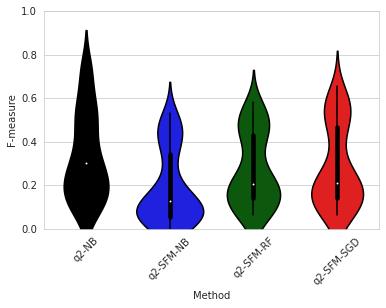

In [8]:
# Optimized method performance
# And, finally, which method performed best at each individual taxonomic level for each reference dataset (i.e., for across all fungal       and bacterial mock communities combined)? 
# For this analysis, we rank the top-performing method/parameter combination for each method at family through species levels. Methods       are ranked by top F-measure, and the average value for each metric is shown (rather than count best as above). F-measure distributions       are plotted for each method, and compared using paired t-tests with FDR-corrected P-values. This cell does not need to be altered,           unless if you wish to change the metric used for sorting best methods and for plotting.
    
boxes_4 = rank_optimized_method_performance_by_dataset(mock_results,
                                                         dataset="Reference",
                                                         metric="F-measure",
                                                         level_range=range(4, 5),
                                                         display_fields=["Method",
                                                                         "Parameters",
                                                                         "Taxon Accuracy Rate",
                                                                         "Taxon Detection Rate",
                                                                         "Precision",
                                                                         "Recall",
                                                                         "F-measure"],
                                                         paired=True,
                                                         parametric=True,
                                                         color=None,
                                                         color_palette=color_palette)
for k, v in boxes_4.items():
    v.get_figure().savefig(join(outdir, 'level-4-fmeasure-{0}-boxplots.pdf'.format(k)),bbox_inches = 'tight')
    
boxes_5 = rank_optimized_method_performance_by_dataset(mock_results,
                                                         dataset="Reference",
                                                         metric="F-measure",
                                                         level_range=range(5, 6),
                                                         display_fields=["Method",
                                                                         "Parameters",
                                                                         "Taxon Accuracy Rate",
                                                                         "Taxon Detection Rate",
                                                                         "Precision",
                                                                         "Recall",
                                                                         "F-measure"],
                                                         paired=True,
                                                         parametric=True,
                                                         color=None,
                                                         color_palette=color_palette)
for k, v in boxes_5.items():
    v.get_figure().savefig(join(outdir, 'level-5-fmeasure-{0}-boxplots.pdf'.format(k)),bbox_inches = 'tight')
        
boxes_6 = rank_optimized_method_performance_by_dataset(mock_results,
                                                         dataset="Reference",
                                                         metric="F-measure",
                                                         level_range=range(6, 7),
                                                         display_fields=["Method",
                                                                         "Parameters",
                                                                         "Taxon Accuracy Rate",
                                                                         "Taxon Detection Rate",
                                                                         "Precision",
                                                                         "Recall",
                                                                         "F-measure"],
                                                         paired=True,
                                                         parametric=True,
                                                         color=None,
                                                         color_palette=color_palette)
for k, v in boxes_6.items():
    v.get_figure().savefig(join(outdir, 'level-6-fmeasure-{0}-boxplots.pdf'.format(k)),bbox_inches = 'tight')